# **Using Auto Encoders for unsupervised labelling of Mars images shot by the Curiosity Rover**
***
By : [Naimish Mani B](https://www.linkedin.com/in/naimish-balaji-a6182b180/)
***

[Dataset](https://dominikschmidt.xyz/mars32k/):
A collection of 32k images shot from the Curiosity Rover at a resolution of 560*500. Used to train the AutoEncoder.

# **Introduction**

The Curiosity Rover stands strong on Mars, performing scientific experiments and sending images back on a regular basis. This provides us with a good repository of images to train an Auto Encoder with. Through the course of this notebook, we wish to acomplish the following objectives:

1. Build and Train an Auto Encoder on the Image Dataset.
2. Save the model to Drive for future access.

So, lets first download and extract the dataset.

In [1]:
# Download Dataset 1
!gdown --id 1yeLkE1p5oeCqa5pA7tc0tI4eoyvjZc5X
!mkdir dataset_1

Downloading...
From: https://drive.google.com/uc?id=1yeLkE1p5oeCqa5pA7tc0tI4eoyvjZc5X
To: /content/mars32k.zip
3.42GB [00:53, 63.4MB/s]


In [ ]:
!unzip mars32k.zip -d dataset_1

# **Pre Processing**

Now that we've downloaded the dataset, we next have to do standardise it (i.e., bring all images to a common base resolution). We do that by first cropping the images down to 500x500, and then bring the images down to a size of 64x64.

First, we go about getting the list of all images for the autoencoder

In [3]:
import glob

ae_images = glob.glob('dataset_1/mars32k/*.jpg')
len(ae_images)

32368

Next, we load the images one by one, crop to 500x500, resize to 64x64 and store these final images in a list.

100%|██████████| 32368/32368 [03:31<00:00, 153.15it/s]


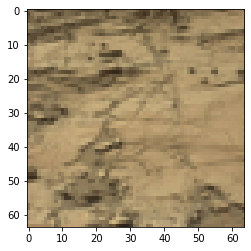

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tqdm

def image_processing_d1(path):
  img = PIL.Image.open(path)
  img = img.crop((30, 0, 530, 500))
  img = img.resize((64, 64))
  foo = np.array(img)
  return foo


AE_DATASET = []

with tqdm.tqdm(total=len(ae_images)) as t:
  for img in ae_images:
    i = image_processing_d1(img)
    #plt.imshow(i)
    #break
    AE_DATASET.append(i)
    t.update(1)

plt.imshow(AE_DATASET[0])

In [5]:
AE_DATASET = np.array(AE_DATASET)
AE_DATASET.shape

(32368, 64, 64, 3)

In [6]:
# Rescale, between 0 and 1
x = AE_DATASET / 255
# Verify if scaped properly
print(x.max(), x.min())
# Print shape for sanity sake
x.shape

1.0 0.0


(32368, 64, 64, 3)

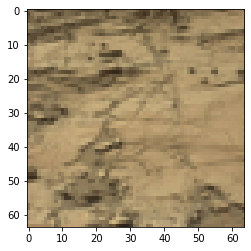

In [7]:
# Function to display image from array
def img_show(img):
  # Clipping between 0 and 1 to prevent overflows
  plt.imshow(np.clip(img, 0, 1))

# Check if it works
img_show(x[0])

In [8]:
# Free up memory because we're running low
del AE_DATASET
del ae_images

# **Auto Encoder**

## Building the Model

In [9]:
from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Reshape, InputLayer, Input
from keras.layers import Conv2D, UpSampling2D, MaxPooling2D

In [ ]:
# Memory cleanup, when re-running training code
del encoder, decoder, autoencoder, inp, code, reconstruction, history

In [10]:
encoder = Sequential()

encoder.add(InputLayer((64,64,3)))
encoder.add(Conv2D(filters = 198, kernel_size = (3, 3), activation='relu', padding='same'))
encoder.add(MaxPooling2D(pool_size = (2, 2), padding='same'))
encoder.add(Conv2D(filters = 256, kernel_size = (3, 3), activation='relu', padding='same'))
encoder.add(MaxPooling2D(pool_size = (2, 2), padding='same'))
encoder.add(Conv2D(filters = 196, kernel_size = (3, 3), activation='relu', padding='same'))
encoder.add(MaxPooling2D(pool_size = (2, 2), padding='same'))
encoder.add(Flatten())
encoder.add(Dense(2500, activation='relu'))
encoder.add(Dense(784, activation='relu'))
encoder.add(Dense(512, activation='relu'))
encoder.add(Dense(256, activation='relu'))

decoder = Sequential()

decoder.add(InputLayer((256)))
decoder.add(Dense(512, activation='relu'))
decoder.add(Dense(784, activation='relu'))
decoder.add(Dense(2500, activation='relu'))
decoder.add(Dense(12544, activation='relu'))
decoder.add(Reshape((8,8,196)))
decoder.add(Conv2D(196, (3, 3), activation='relu', padding='same'))
decoder.add(UpSampling2D((2, 2)))
decoder.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
decoder.add(UpSampling2D((2, 2)))
decoder.add(Conv2D(198, (3, 3), activation='relu', padding='same'))
decoder.add(UpSampling2D((2, 2)))
decoder.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

inp = Input((64,64,3))
code = encoder(inp)
reconstruction = decoder(code)

print(encoder.summary())
print(decoder.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 198)       5544      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 198)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 256)       456448    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 196)       451780    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 196)         0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [11]:
autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 256)               34770304  
_________________________________________________________________
sequential_1 (Sequential)    (None, 64, 64, 3)         35128339  
Total params: 69,898,643
Trainable params: 69,898,643
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Compile
# Session keeps crashing, need to fix later
history = autoencoder.fit(
    x = x,
    y = x,
    epochs=150,
    batch_size=256
)

Epoch 1/150
127/127 [==============================] - 111s 447ms/step - loss: 0.0201
Epoch 2/150
127/127 [==============================] - 53s 420ms/step - loss: 0.0154
Epoch 3/150
127/127 [==============================] - 53s 418ms/step - loss: 0.0166
Epoch 4/150
127/127 [==============================] - 53s 421ms/step - loss: 0.0140
Epoch 5/150
127/127 [==============================] - 53s 421ms/step - loss: 0.0083
Epoch 6/150
127/127 [==============================] - 54s 422ms/step - loss: 0.0068
Epoch 7/150
127/127 [==============================] - 54s 421ms/step - loss: 0.0065
Epoch 8/150
127/127 [==============================] - 53s 421ms/step - loss: 0.0063
Epoch 9/150
127/127 [==============================] - 53s 421ms/step - loss: 0.0059
Epoch 10/150
127/127 [==============================] - 54s 422ms/step - loss: 0.0057
Epoch 11/150
127/127 [==============================] - 54s 423ms/step - loss: 0.0055
Epoch 12/150
127/127 [==============================] - 54s 42

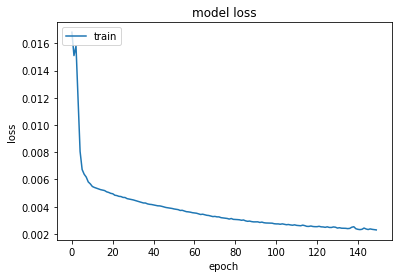

In [13]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Visualising Reconstructions


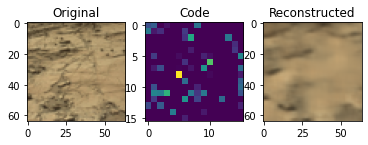

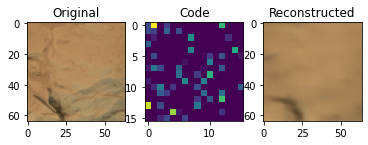

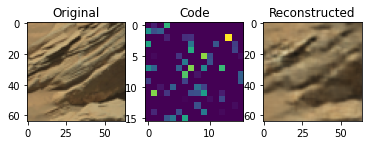

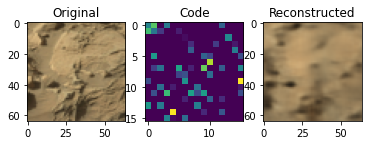

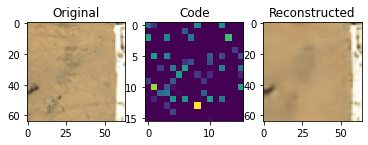

In [14]:
# Reconstruction success
def visualize(img,encoder,decoder):
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    img_show(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape((16,16)))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    # reco = reco * 255
    # img_show(reco)
    plt.imshow(reco)
    plt.show()

for i in range(5):
    img = x[i]
    # print(img.shape)
    # print(img[None].shape)
    visualize(img,encoder,decoder)

## Perform t-SNE to visualise latent vectors

In [15]:
from sklearn.manifold import TSNE
x_viz = x[:1000]
x_compressed = encoder.predict(x_viz)
tsne = TSNE()
x_2D = tsne.fit_transform(x_compressed)
x_2D = (x_2D - x_2D.min()) / (x_2D.max() - x_2D.min())

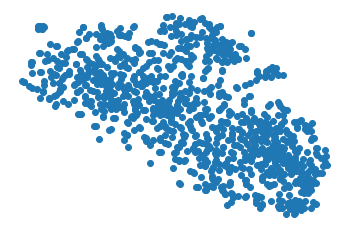

In [16]:
plt.scatter(x_2D[:, 0], x_2D[:, 1])
plt.axis("off")
plt.show()

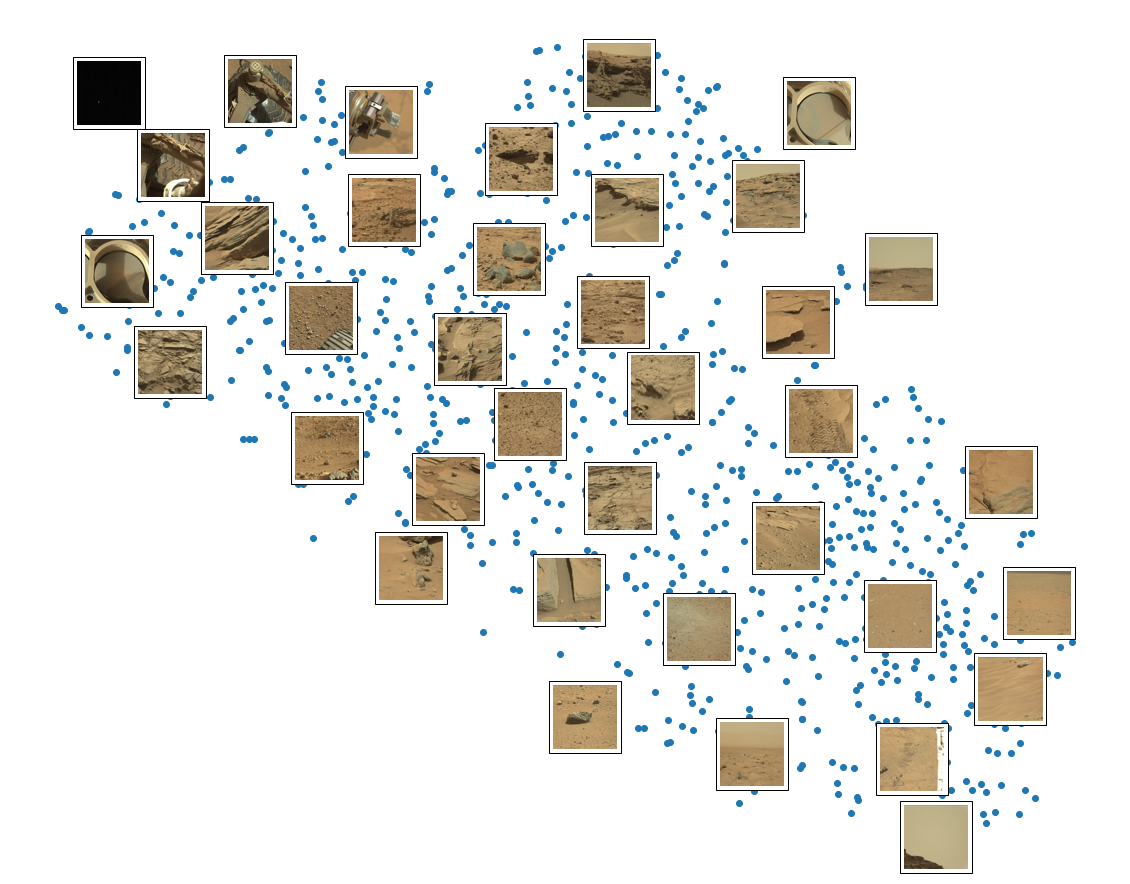

In [17]:
# Adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
import matplotlib as mpl

plt.figure(figsize=(20, 16))
plt.scatter(x_2D[:, 0], x_2D[:, 1])
image_positions = np.array([[1., 1.]])
for index, position in enumerate(x_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.01: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_viz[index]),
            position)
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

## Save the Model

In [18]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [21]:
encoder.save('/content/drive/MyDrive/CuriosityAE/encoder')
decoder.save('/content/drive/MyDrive/CuriosityAE/decoder')
autoencoder.save('/content/drive/MyDrive/CuriosityAE/autoencoder')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/CuriosityAE/decoder/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/CuriosityAE/autoencoder/assets


In [22]:
!cd /content/drive/MyDrive/CuriosityAE && ls

autoencoder  decoder  encoder
